## Newton's Method

This is an implementation of the coding challenge of week2 of the Math of Intelligence course.
In this challenge we will implement newston's method that is used for root finding and second order optimization using numpy.
Awesome reference about newton's method: 
http://thelaziestprogrammer.com/sharrington/math-of-machine-learning/solving-logreg-newtons-method

In [1]:
import numpy as np
from sympy import *
from sympy.parsing import sympy_parser as spp
from sklearn import datasets
import matplotlib.pyplot as plt

init_printing(use_unicode=True)
%matplotlib notebook

First, we will look at newton's method to find roots of a polynomial (also called newton-raphson method).

#### What is a root?
For a polynomial f(x) a root x0 of this polynomial upholds:\begin{equation*}
f(x_0) = 0
\end{equation*}

#### The idea
First, let's look at the problem of finding roots of a function f(x) in 2D.
By using newton's method we will start with a random guess $x_0$ and update our guess using the following update rule:
$x_{n+1} = x_n - f(x_n) / f'(x_n)$
We will use this update rule iteratively until a good approximation is reached.
Let's understands the meaning of this update rule, $f'(x_n)$ stands for the **derivative** of our polynomial at the point of our current root guess $x_n$. The derivative of our polynomial f by x indicates the **rate of change** of f relatively to x if we will change x by a small margin.If it's positive it means the value f(x) will increase and if it's negative it means it will decrease.
So the expression $f(x_n)/f'(x_n)$ will **always** go at the direction of the root.Why? Because if our polynomial increases at $x_n$ our update rule will reduce the absolute value of our root guess (whether it was positive or negative,same for $f(x_n)$),same for the case that the polynomial decreases at $x_n$.

When we will stop using the update rule and get our final guess?
We will use some boundary value $epsilon$ such that when $abs(x_n) < epsilon$ we will stop iterating.

Cool graph that shows our update rule:
![title](root_img.gif)



Now let's get to the code:

In [2]:
def dx(f,x):
    return abs(f(x))

def newton_root_find(f,df,x0,e):
    '''
    Perform the newton-raphson method to find a root of a given function f.
    Parameters:
        -f: The function that we will find it's root.
        -df: The function's derivative.
        -x0: Our starting guess.
        -e : Our boundary epsilon,when abs(x0) will be lower than it we
             will stop.
    '''
    delta = dx(f,x0)
    while delta > e:
        x0 = x0 - f(x0)/df(x0)
        delta = dx(f,x0)
    print("Final root: " + str(x0))
    print("Value at root: " + str(f(x0)))

Let's test our implementation using some sample function.

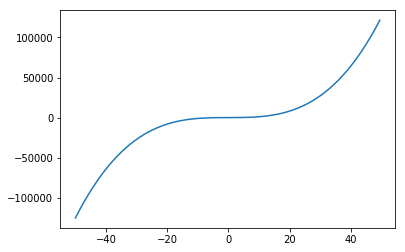

Final root: 0.875
Value at root: 0.044921875


In [3]:
def plot_formula(formula,x_range):
    '''
    Plot a 2d graph using a given formula.
    '''
    x = np.array(x_range)
    y = formula(x)
    plt.plot(x,y)
    plt.show()

def example_func(x):
    return x**3 + 5*x -5

plot_formula(example_func,np.arange(-50,50,.5))
derivative = lambda x: 3 * x ** 2 + 5
newton_root_find(example_func,derivative,1,0.05)


### Newton optimization method

Differently from gradient descent which we looked at the previous lesson,newton's optimization method looks at the **second derivative** of our loss function in order to optimize our loss (in case of multidimensional functions we will refer to the **Hessian Matrix**).
In the optimization case we will try to find the value $x_n$ such that our derivative will be equal to zero: $f'(x_n) = 0$. So it's pretty trivial (basic calculus) that when our derivative will get closer to zero we will reach **local minima**.

There are two cases for implementing newton's optimization method: the 1D case and the multi-dimensional case.
We will implement the method for both cases.

First let's implement the optimization process for the first order optimization case.

In [4]:
#The range of our plot
plot_from,plot_to,plot_step = -7.0,7.0,0.1

#The range of precision we will target.
target_precision = 0.3

#Create a matrix of the symbols that we will use.
m = Matrix(symbols('x1 x2'))


def dfdx(x,gradient):
    '''
    Compute value of the gradient at a given point x.
    Parameters:
        - x : The value we will compute the gradient at.
        - gradient: The gradient (using sympy expression)
    Returns:
        - value of the gradient at x.
    '''
    return [gradient[i].subs(m[0],x[0]).subs(m[1],x[1]) for i in range(len(gradient))]

def steepest_descent(obj,x_start,x_res,lr = 0.0002):
    '''
    This is a first order optimization algorithm.
    Parameters:
        -lr: Stands for the learning rate that we will use in our
             update rule.
        -obj: Sympy expression that we will optimize.
        -x_start: Starting point for our optimization.
        -x_res: Ending point for our optimization.
    Returns: void
    
    '''
    #First compute the gradient,derivative by each variable.
    gradient = [diff(obj,i) for i in m]
    #Initialize our current value (default will be 0).
    x_vals = [[0.0,0.0]]
    x_vals[0] = x_start
    #Save current number of iteration.
    num_iter = 0
    #Loop until the distance between the previous iteration value
    # to the current value is smaller than our target distance.
    while (np.linalg.norm((np.array(x_vals[-1]) - x_res).astype(int)) 
           > target_precision):
        #Compute gradients at current point
        #print("Current point:",x_vals[-1])
        grads = dfdx(x_vals[num_iter],gradient)
        
        #Update current value.
        #print("Grads: ",grads)
        x_vals.append(x_vals[num_iter] - np.dot(lr,grads))
        num_iter += 1
        #Stop after a thousand iterations
        if (num_iter > 1000):
            break
    print("Steepest descent final result distance: ",
          np.linalg.norm((np.array(x_vals[-1]) - x_res).astype(int)))
    print("Final point steepest descent: ",x_vals[-1])
    #Plot our results.
    x_vals = np.array(x_vals)
    plt.plot(x_vals[:,0],x_vals[:,1],'g-o')

Now let's implement the same optimization process for second order optimization using newton's method.

In [5]:
def newton_optimization(obj,x_start,x_res):
    '''
    Newton's method for second order optimization.
    Parameters:
        -obj: Sympy expression that we will optimize.
        -x_start: Starting point for our optimization.
        -x_res: Ending point for our optimization.
    '''
    #Compute the gradient.
    gradient = [diff(obj,i) for i in m]
    
    #Hessian matrix.
    H = Matrix([[diff(partial_deriv,i) for i in m]
                for partial_deriv in gradient])
    H_inv = H.inv()
    
    x_vals = [[0,0]]
    x_vals[0] = x_start
    
    num_iter = 0
    #Loop until the distance between our current point to the final one
    #is smaller that the target precision.
    while(np.linalg.norm(
        (np.array(x_vals[-1]) - x_res).astype(int)) > target_precision):
        grads = Matrix(dfdx(x_vals[num_iter],gradient))
        
        #Compute the amount we will change our current value xn by:delta
        delta = -H_inv * grads
            
        #Evaluate delta's value for x_n.
        delta_xn = delta.subs(m[0],x_vals[num_iter][0]).\
                    subs(m[1],x_vals[num_iter][1])
        x_vals.append(Matrix(x_vals[num_iter]) + delta_xn)
        
        num_iter += 1
    
    print("Final result newton's method: ",np.linalg.norm(
        (np.array(x_vals[-1]) - x_res).astype(int)))
    print("Final point newtons:",x_vals[-1])
    
    #Plot our final results.
    x_vals = np.array(x_vals)
    plt.plot(x_vals[0,:],x_vals[1,:],'k-o')
    

Now, we have a template for the optimization algorithms for both first order optimization and second order optimization.
Let's test it out by optimizing some given function using both of those algorithms starting at the same starting point.

Final result newton's method:  0.0
Final point newtons: Matrix([[0], [8.88178419700125e-16]])
Steepest descent final result distance:  0.0
Final point steepest descent:  [-0.944000000000000 -0.285440000000000]


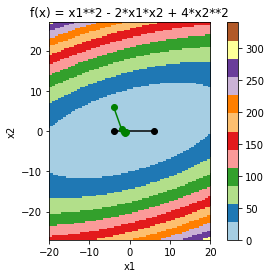

In [6]:
#Our chosen starting location.
x_start = [-4.0,6.0]

#Obj will save the expression that we will optimize.
obj = spp.parse_expr('x1**2 -2 * x1 * x2 + 4 * x2**2')

#Final result that we expect.
x_result = np.array([0,0])

#Create all the points we will plot using meshgrid.
i1 = np.arange(plot_from,plot_to,plot_step)
i2 = np.arange(plot_from,plot_to,plot_step)
mesh_d1,mesh_d2 = np.meshgrid(i1,i2)

#Evaluate our function in each point of the meshgrid.
#First let's change our expression so that it uses our grid's points.
meshgrid_str = obj.__str__().replace('x1','mesh_d1').replace('x2','mesh_d2')
mesh_result = eval(meshgrid_str)

#Create our contour plot.
plt.figure()

plt.imshow(mesh_result,cmap='Paired',origin='lower',
          extent=[plot_from - 20, plot_to + 20, plot_from - 20, plot_to + 20])
plt.colorbar()

# Add some text to the plot
plt.title('f(x) = ' + str(obj))
plt.xlabel('x1')
plt.ylabel('x2')


#Now let's plot the progress of each algorithm in our figure.
newton_optimization(obj,x_start,x_result)
steepest_descent(obj,x_start,x_result,lr=0.1)
plt.xlim(-20,20)
plt.show()


If you look closely at the contour plot above we can clearly see that for the equation above the second order optimization converges much faster(lower number of points).

### Working with a dataset
We will compare convergence between the first order and second order optimization algorithms using the diabetes dataset from sklearn.
We will use only **one** feature of the diabetes dataset and use linear regression in order to classify it.
In order to compute the jacobian and hessian of our loss function we will use numerical computing of the derivative using the following definition of the derivative.
$$f'(x_n) = \lim_{\delta\to0}\frac{f(x_n +\delta) - f(x_n)}{\delta}$$

In case where our loss function is quite complex we can use the derivative's definition to compute the derivative approximately using the numerical method.
In our case the loss function is a simple mean square error so a much nicer way to do this would be to compute the derivatives analytically (it also helps that our dimension is very slim in this example).




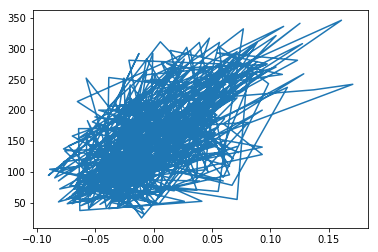

In [7]:
diabetes = datasets.load_diabetes()

#We will work only using one feature.
X = np.array(diabetes['data'])[:,np.newaxis,2]
X_train = X[:-50]
Y = np.array(diabetes['target'])
Y_train = X[:-50]

#Plot our data.
plt.plot(X,Y)

Number of epochs:  20


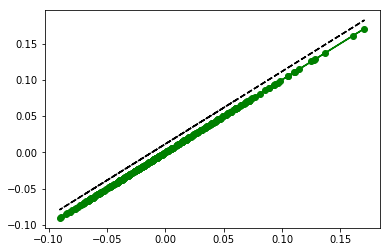

In [37]:
def predict(x,m,b):
    #No need to use for loop because numpy is awesome.
    return m * x + b

def mean_squared_error(x,y,m,b):
    y_pred = predict(x,m,b)
    loss = float(np.sum(np.square(y_pred - y))) / (y.shape[0])
    return loss

def analytical_gradient(x,y,m,b):
    res = m * x + b - y
    grads = np.zeros(2)
    
    #Compute analytical gradients.
    grads[0] = np.sum(res * x)
    grads[1] = np.sum(res)
    
    return grads * 2 / x.shape[0]
    
def gradient_descent(X,Y,m,b,lr = 0.1,epochs = 20):
    '''
    Implementation of gradient descent using numerical gradient.
    X:the data batch
    '''
#     print("Training shape: ",X.shape)
    for i in range(epochs):
        grads = analytical_gradient(X,Y,m,b)
        
        #Update the weights.
        m -= lr * grads[0]
        b -= lr * grads[1]
    return m,b

#Test out our numerical gradient descent algorithm.
m = b = 1.0
m,b = gradient_descent(X_train,Y_train,m,b,epochs=20)
print("Number of epochs: ",20)
plt.figure()
plt.plot(X_train,predict(X_train,m,b),'k--')
plt.plot(X_train,Y_train,'g-o')


We can see that our model trained well using the simple gradient descent optimization algorithm. Let's check out the difference when we use newton's method for the function's optimization.

End loss  1.0559610003386231e-31
End loss  1.2669550082204502e-39
Number of steps:  2


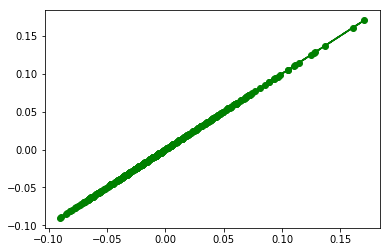

In [35]:
def analytical_hessian(X,Y,m,b):
    '''
    Compute the hessian analyticaly.
    '''
    H = np.zeros((2,2))
    H[0][0] = np.sum(np.square(X))
    H[0][1] = np.sum(X)
    H[1][0] = np.sum(X)
    H[1][1] = X.shape[0]
    
    return 2 * H / X.shape[0]

def newtons(X,Y,m,b,tol=1e-4):
    error = 10
    steps = 0
    
    while (error > tol):
        start_loss = mean_squared_error(X,Y,m,b)
        steps += 1
        
        H = analytical_hessian(X,Y,m,b)
        grads = analytical_gradient(X,Y,m,b)
        
        update_rule = np.dot(np.linalg.pinv(H),grads)
        
        m -= update_rule[0]
        b -= update_rule[1]
        
        end_loss = mean_squared_error(X,Y,m,b)
        
        error = np.abs(end_loss - start_loss)
    
    return m,b,steps

m = b = 1.0
m,b,steps = newtons(X_train,Y_train,m,b)

print("Number of steps: ",steps)

plt.figure()
plt.plot(X_train,predict(X_train,m,b),'k--')
plt.plot(X_train,Y_train,'g-o')

We can see that using newton's method our model trained **much** faster, running for only 2 iterations.
In practice the major hurdle in using newton's method is the need to compute the inverse of the hessian on every step which is a pretty heavy computation to make.